In [117]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import cv2
import moviepy.editor as mp
from moviepy.video.io.bindings import mplfig_to_npimage
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import VideoFileClip, ImageSequenceClip, CompositeVideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


In [120]:
output_dir = 'output'
plot_output_dir = f'{output_dir}/plot'
video_output_dir = f'{output_dir}/visualized_video'

data_dir = '/home/kesharaw/Downloads/GX010305_clipped_with_audio.mp4'
annotations_file = './via_project_28Aug2024_11h02m15s.json'

# strip the file extension and add _with_timeline.mp4
video_file = data_dir
file_name = video_file.split('/')[-1]
output_file = file_name.split('.')[0] + "_with_timeline.mp4"
timeline_output_file = file_name.split('.')[0] + "_timeline_only.mp4"
final_output_path = f'{video_output_dir}/{output_file}'

# make dirs if not exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)


Segments: [(0.008, 2.88275, 'approach_patient'), (2.79942, 5.13275, 'check_responsiveness'), (5.133, 7.52858, 'check_pulse_breathing'), (7.52858, 53.40358, 'begin_chest_compression'), (53.404, 54.90358, 'no_action'), (54.96608, 57.90358, 'take_defib_pads'), (58.02858, 60.46608, 'attach_defib_pads'), (60.46608, 61.19525, 'take_defib_pads'), (61.21608, 63.34, 'attach_defib_pads'), (63.36192, 79.17442, 'begin_chest_compression'), (79.40358, 88.19525, 'administer_shock_aed'), (88.23692, 106.29942, 'begin_chest_compression'), (106.299, 107.44525, 'place_bvm'), (107.445, 112.23692, 'compress_bvm'), (112.121, 125.76034, 'begin_chest_compression'), (126.28811, 127.70478, 'place_bvm'), (127.773, 131.37145, 'compress_bvm'), (127.773, 128.773, 'begin_chest_compression'), (131.258, 145.34937, 'begin_chest_compression'), (145.349, 154.53118, 'administer_shock_aed')]


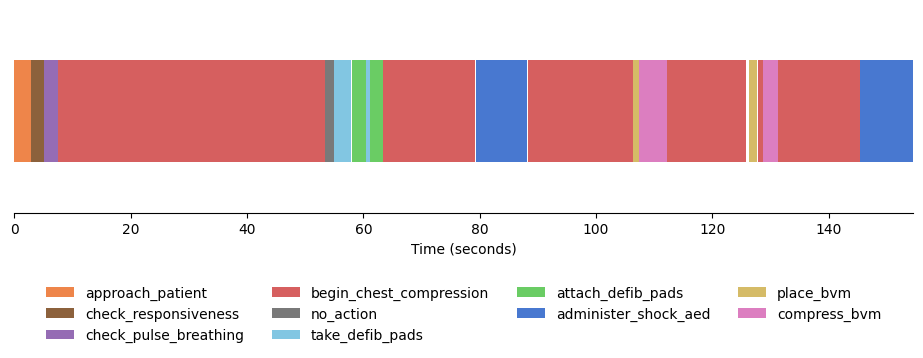

In [121]:

# Load JSON
with open(annotations_file) as f:
    data = json.load(f)

# Extract temporal segments
segments = []
for meta in data['metadata'].values():
    start, end = meta['z']
    label = meta['av']['1']
    segments.append((start, end, label))

print("Segments:", segments)

# Generate a custom color palette with enough distinct colors
unique_labels = sorted(set([label for _, _, label in segments]))
palette = sns.color_palette("muted", len(unique_labels))  # "husl" generates distinct colors
color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

# Video file path
video_file = data_dir  # Update the path

# Open video file
cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print("Error: Could not open video.")
else:
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps == 0:
        print("Error: FPS value is zero, which might indicate an issue with the video file.")
    else:
        # Plot timeline
        fig, ax = plt.subplots(figsize=(10, 4))  # Adjusted figure size for better appearance
        ax.set_xlim(0, max([end for _, end, _ in segments]))
        ax.set_ylim(0, 1)

        # Remove y-axis ticks, labels, and spines
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # set x axis label
        ax.set_xlabel("Time (seconds)")
        # Track which labels have been added to the legend
        labels_added = set()

        for start, end, label in segments:
            color = color_map[label]
            if label not in labels_added:
                ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color, label=label)
                labels_added.add(label)
            else:
                ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

        # Add legend below the x-axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=4, frameon=False)

        # Sync video playback
        def update(frame):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
            ret, frame_img = cap.read()
            if ret:
                plt.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))
            return frame_img

        ani = FuncAnimation(fig, update, frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), interval=1000/fps)

        plt.tight_layout()

        fig.savefig(f'{plot_output_dir}/{file_name}_timeline.png', bbox_inches='tight')

        plt.show()



cap.release()


## Visualize above on the video

In [122]:

# Load the video with MoviePy
video_clip = VideoFileClip(video_file)
fps = video_clip.fps
duration = video_clip.duration

# Prepare to create timeline frames
frames = []

for t in np.linspace(0, duration, int(fps * duration)):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(0, max([end for _, end, _ in segments]))
    ax.set_ylim(0, 1)

    # Remove y-axis ticks, labels, and spines
    ax.yaxis.set_ticks([])
    ax.yaxis.set_ticklabels([])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

    # set x axis label
    ax.set_xlabel("Time (seconds)")
    # Track which labels have been added to the legend
    labels_added = set()

    for start, end, label in segments:
        color = color_map[label]
        if label not in labels_added:
            ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color, label=label)
            labels_added.add(label)
        else:
            ax.broken_barh([(start, end - start)], (0.25, 0.5), facecolors=color)

    # Add legend below the x-axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=4, frameon=False)
    # Add a moving cursor
    ax.axvline(t, color='red', linewidth=2)
    
    fig.tight_layout()
    fig.canvas.draw()
    
    img_plot = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(img_plot)
    plt.close(fig)
    # break


# Create a clip from the frames
timeline_clip = ImageSequenceClip(frames, fps=fps)
timeline_clip = timeline_clip.set_duration(duration).resize(width=video_clip.w)

timeline_output_path = f'{video_output_dir}/{timeline_output_file}'
timeline_clip.write_videofile(timeline_output_path, fps=fps)



Moviepy - Building video output/visualized_video/GX010305_clipped_with_audio_timeline_only.mp4.
Moviepy - Writing video output/visualized_video/GX010305_clipped_with_audio_timeline_only.mp4



Moviepy - Done !
Moviepy - video ready output/visualized_video/GX010305_clipped_with_audio_timeline_only.mp4


### Use ffmpeg to combine videos

In [123]:
# execute shell commmand
original_file = data_dir

# update command to forcefully overwrite the output file
command = f'ffmpeg -i {original_file} -i {timeline_output_path} -filter_complex "[1:v]fps=fps=30[v1];[0:v][v1]vstack=inputs=2" -c:v libx264 -c:a copy -r 30 -y {final_output_path}'

! {command}

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/kesharaw/anaconda3/envs/cogems --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc 

In [92]:
frames[0].shape
# convert to pil image
from PIL import Image
img = Image.fromarray(frames[0])

# save image
img.save('test.png')



### Code to visualize label on the video

In [11]:
import json
import cv2
import matplotlib.pyplot as plt

# Load VIA annotation file
annotation_file = './via_project_28Aug2024_11h02m15s.json'

with open(annotation_file, 'r') as file:
    annotations = json.load(file)

# Extract relevant information from the JSON
video_info = annotations['file']['1']
video_filename = video_info['fname']
metadata = annotations['metadata']

# Load the video
cap = cv2.VideoCapture(video_filename)
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
output_filename = 'annotated_video_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
out = cv2.VideoWriter(output_filename, fourcc, frame_rate, (frame_width, frame_height))

# Function to add annotation text on frames
def add_annotation(frame, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    font_scale = 1
    color = (255, 0, 0)
    thickness = 2
    frame = cv2.putText(frame, text, org, font, font_scale, color, thickness, cv2.LINE_AA)
    return frame

# Process each annotation and save to video
for key, value in metadata.items():
    # Extract start time, end time, and label
    start_time = value['z'][0]
    end_time = value['z'][1]
    label = value['av']['1']
    
    # Convert times to frame numbers
    start_frame = int(start_time * frame_rate)
    end_frame = int(end_time * frame_rate)
    
    # Set the video to the start frame of the segment
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Write frames with annotation to output video
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if ret:
            # Add annotation text to frame
            annotated_frame = add_annotation(frame, f"Label: {label}")
            # Write the frame to the output video
            out.write(annotated_frame)
        else:
            print(f"Failed to read frame at {frame_num}.")
            break

# Release the video capture and writer objects
cap.release()
out.release()

print(f"Annotated video saved to {output_filename}")
